**Projet segmentation sémantique 2024 - IOGS/ATSI- Dataset SUIM:**

***Introduction:***

La segmentation sémantique des fonds marins est un domaine crucial dans la compréhension et l'exploration des environnements sous-marins. Ce projet vise à développer des méthodes avancées d'apprentissage automatique pour segmenter de manière précise et efficace les objets et les structures présents dans les images sous-marines.

Le problème de la segmentation sémantique d'images sous-marines est abordé en utilisant la base de données SUIM, qui comprend une vaste collection d'images annotées représentant diverses conditions et scènes sous-marines. Cette base de données choisie de classifier les objets contenus dans les images en huit catégories: le fond marin; les plongeurs; les plantes aquatiques; les épaves; les robots; les récifs; les poissons et les rochers. C'est à dire que l'annotation suit ces huits catégories.

Plusieurs stratégies sont envisagées pour aborder ce problème, notamment l'entraînement et la comparaison de différents modèles d'apprentissage automatique. Ces stratégies reposent sur l'utilisation de données expérimentales, du jeu de données SUIM, ainsi que sur le framework utilisé keras ou pytorch.

Parmi les modèles développés pour ce projet, on distingue SUIM-Net (RSB) et SUIM-Net (VGG). SUIM-Net (RSB) est un modèle simple et léger qui offre des performances raisonnables à un rythme rapide, tandis que SUIM-Net (VGG) fournit une meilleure performance de généralisation grâce à l'utilisation d'une architecture basée sur VGG. Ces deux modèles constituent des approches efficaces pour la segmentation sémantique des fonds marins et sont évalués dans le cadre de ce projet.

***Importation des bibliothèques et des modules nécessaires pour le projet de segmentation sémantique :***  

In [ ]:
import logging
import os
import torch
import numpy
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from collections import OrderedDict
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

***Importation du module drive depuis la bibliothèque google.colab et utilisation de la fonction mount() pour monter le Google Drive dans l'environnement de travail actuel de Google Colab.***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Comptage du nombre d'images dans les deux folders: "/content/drive/My Drive/segmentation_project/train_val/images" et "/content/drive/My Drive/segmentation_project/train_val/train_label"***

---



In [ ]:
import os
import glob

# Définition de la fonction pour compter le nombre d'images dans un dossier donné
def count_images_in_folder(folder_path):
    # Changement du répertoire de travail actuel pour celui spécifié par folder_path
    os.chdir(folder_path)
    # Les extensions d'images prises en compte sont jpg, jpeg, png, gif, bmp
    image_files = glob.glob("*.jpg") + glob.glob("*.jpeg") + glob.glob("*.png") + glob.glob("*.gif") + glob.glob("*.bmp")

    # Affichage du nombre d'images trouvé dans le dossier
    print("Nombre d'images dans le dossier :", len(image_files))

# Chemin vers les images
folder_path_train_val_images = "/content/drive/My Drive/segmentation_project/train_val/images"
count_images_in_folder(folder_path_train_val_images)

# Chemin vers les étiquettes de formation
folder_path_train_val_train_label = "/content/drive/My Drive/segmentation_project/train_val/train_label"
count_images_in_folder(folder_path_train_val_train_label)



Nombre d'images dans le dossier : 1525
Nombre d'images dans le dossier : 1525


Le résultat de la sortie indique que les deux dossiers "/train_val/images" et "/train_val/train_label" contiennent chacun 1525 images.

***Paramètres:***

In [ ]:
batch_size = 1
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
epochs = 5
image_size = 256
learning_rate = 1e-3
num_classes = 8

Les paramètres montrés ci-dessus sont définis pour l'entraînement du modèle de segmentation sémantique. Un batch_size de 1 signifie que chaque mise à jour des poids du modèle est calculée sur une seule image à la fois, ce qui est utile dans notre cas où la mémoire GPU est limitée. Le choix du device, qui utilise CUDA s'il est disponible, permet d'exploiter la puissance de calcul du GPU pour accélérer l'entraînement du modèle. le modèle voit l'ensemble de données d'entraînement cinq fois. Un learning_rate de 1e-3 contrôle la taille des pas de mise à jour des poids du modèle lors de l'optimisation. Enfin, avec num_classes fixé à 8, le modèle est configuré pour segmenter huit catégories différentes dans les images, comme dit dans l'introduction.

In [ ]:
#         DataAugment
def random_rot_flip(image, label):
    k = numpy.random.randint(0, 4)
    image = numpy.rot90(image, k)
    label = numpy.rot90(label, k)
    axis = numpy.random.randint(0, 2)
    image = numpy.flip(image, axis=axis).copy()
    label = numpy.flip(label, axis=axis).copy()
    return image, label

def random_rotate(image, label):
    angle = numpy.random.randint(-40, 40)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0, reshape=False)
    return image, label

def randomGaussian(image, label, mean=0.2, sigma=0.3):
    def gaussianNoisy(im, mean=0.2, sigma=0.3):
        """
        Gaussian noise processing of images
        :param im: Single-channel images
        :param mean: Offset
        :param sigma: Standard deviation
        :return:
        """
        for _i in range(len(im)):
            im[_i] += random.gauss(mean, sigma)
        return im

     # Converting images into arrays
    img = numpy.asarray(image)
    img.flags.writeable = True  # Changing arrays to read and write mode
    width, height = img.shape[:2]
    img_r = gaussianNoisy(img[:, :, 0].flatten(), mean, sigma)
    img_g = gaussianNoisy(img[:, :, 1].flatten(), mean, sigma)
    img_b = gaussianNoisy(img[:, :, 2].flatten(), mean, sigma)
    img[:, :, 0] = img_r.reshape([width, height])
    img[:, :, 1] = img_g.reshape([width, height])
    img[:, :, 2] = img_b.reshape([width, height])
    return numpy.uint8(img), label

class RandomGenerator(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if random.random() > 0.5:
            image, label = random_rot_flip(image, label)
            if random.random() > 0.5:
                image, label = randomGaussian(image, label)
        elif random.random() > 0.5:
            image, label = random_rotate(image, label)
            if random.random() > 0.5:
                image, label = randomGaussian(image, label)
        elif random.random() > 0.5:
            image, label = randomGaussian(image, label)


        return image, label

* La fonction random_rot_flip(image, label) effectue une rotation aléatoire de l'image et de son étiquette de 90 degrés dans le sens horaire. Ensuite, elle applique une réflexion horizontale ou verticale de manière aléatoire sur l'image et l'étiquette.
* La fonction random_rotate(image, label) effectue une rotation aléatoire de l'image et de son étiquette autour de leur centre dans une plage d'angles spécifiée.
* La fonction randomGaussian(image, label, mean=0.2, sigma=0.3) ajoute du bruit gaussien à l'image. Elle génère du bruit en ajoutant un échantillon aléatoire à chaque pixel de l'image, tiré d'une distribution gaussienne avec une moyenne et écart-type spécifiés.
* La classe RandomGenerator agit comme un transformateur personnalisé pour les ensembles de données. Elle applique aléatoirement les transformations précédentes sur chaque échantillon d'image et d'étiquette. La probabilité pour chaque transformation est de 0.5, donc chaque transformation a une chance égale d'être appliquée. Elle retourne l'image et l'étiquette résultantes après avoir appliqué les transformations aléatoires.

***DataLoader:***

In [ ]:
class SUIM(Dataset):
    def __init__(self, img_path, label_path, transform = None):
        self.img_path = img_path
        self.label_path = label_path
        self.label_data = [file for file in os.listdir(self.label_path) if file.endswith('.bmp')] # Ensure only BMP files are considered
        # print(self.label_data[-1])
        # print(len(self.label_data))
        self.transform = transform # Data enhancement
        self.resize = transforms.Resize((image_size, image_size)) # Trimming of data
    def __len__(self):
        return len(self.label_data)  # Number of data returned

    def __getitem__(self, item):
        img_name = os.path.join(self.img_path, self.label_data[item]) # 'dataset/training/picture' +‘00001_matte.png’
        img_name = os.path.split(img_name) # 'dataset/training/picture/00001_matte.png' -> ('dataset/training/picture','00001_matte.png')
        img_name = img_name[-1] #'00001_matte.png'
        img_name = img_name.split('.')
        img_name = img_name[0] + '.jpg'   #  '00001' + ‘.png’ is the file name of the data
        img_data = os.path.join(self.img_path, img_name) # 'dataset/training/picture/00001.png'
        label_data =os.path.join(self.label_path, self.label_data[item])

        img = Image.open(img_data)
        label = Image.open(label_data)
        img = self.resize(img)
        label = self.resize(label)
#         print(numpy.shape(img))
        img = numpy.array(img)

        label = numpy.array(label)
        sample = {'image': img, 'label': label}
        if self.transform:
            img, label = self.transform(sample)

        return img, label
'''The dataloader is loaded, and when it is loaded, it is processed in the trainloader.（img，label）'''

train_dataset = SUIM('/content/drive/MyDrive/segmentation_project/train_val/images',
                       '/content/drive/MyDrive/segmentation_project/train_val/train_label',
                       transform=transforms.Compose(
                                   [RandomGenerator(output_size=[image_size, image_size])]))

test_data = SUIM('/content/drive/MyDrive/segmentation_project/test/images', '/content/drive/MyDrive/segmentation_project/test/test_label', transform=None)

train_data, val_data = torch.utils.data.random_split(train_dataset, [1220, 305], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, num_workers=0,
                          drop_last=True)

val_loader = DataLoader(val_data, batch_size=batch_size,
                          shuffle=False, num_workers=0,
                          drop_last=True)

test_loader = DataLoader(test_data, batch_size=1,
                          shuffle=False, num_workers=0,
                          drop_last=True)

Le code ci -dessus définit un DataLoader pour charger et prétraiter des données d'images et d'étiquettes à partir de chemins spécifiés vers des fichiers d'images et des étiquettes (train_dataset et test_data). Il utilise la classe SUIM comme source de données, qui hérite de la classe Dataset de PyTorch. Le DataLoader charge les données d'entraînement, de validation et de test, et les organise en lots pour pouvoir charger les données pendant l'entraînement, la validation et le test du modèle.

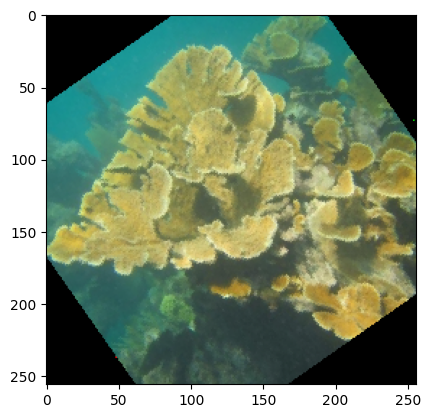

torch.Size([256, 256, 3])


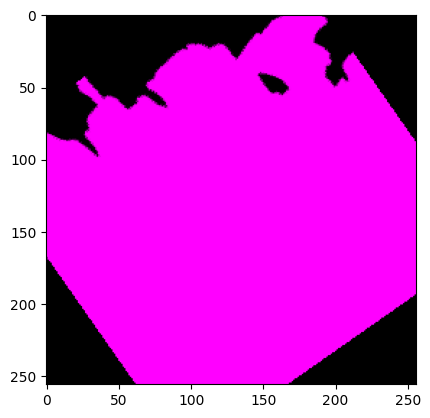

In [ ]:
for data, mask in train_loader:

    data1 = data[0]
    plt.imshow(data1)
    plt.show()
    plt.imshow(mask[0])
    print(mask[0].shape)
    plt.show()
    break

***Modèle SUIM_NET.py en utilisant Keras:***

Dans cette partie,on va implémenter le modèle suim_net.py en utilisant Keras comme montrée sur la page github du projet. Pour se faire, on va commencer par l'importation des deux frameworks tensorflow et Keras

In [ ]:
import tensorflow as tf
from keras.layers import Input,UpSampling2D, Conv2D
from keras.models import Model
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.layers import add, Lambda, Concatenate, ZeroPadding2D
from keras.optimizers import Adam, SGD
from keras.applications.vgg16 import VGG16

In [ ]:
def RSB(input_tensor, kernel_size, filters, strides=1, skip=True):
    """
       A residual skip block
    """
    f1, f2, f3, f4 = filters
    ## sub-block1
    x = Conv2D(f1, (1, 1), strides=strides)(input_tensor)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation('relu')(x)
    ## sub-block2
    x = Conv2D(f2, kernel_size, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation('relu')(x)
    ## sub-block3
    x = Conv2D(f3, (1, 1))(x)
    x = BatchNormalization(momentum=0.8)(x)
    ## skip connetion based on the given choice
    if skip:
        shortcut = input_tensor
    else:
        shortcut = Conv2D(f4, (1, 1), strides=strides)(input_tensor)
        shortcut = BatchNormalization(momentum=0.8)(shortcut)
    ## complete connection and activation
    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x


def Suim_Encoder_RSB(inp_res, channels=1):
    """
       SUIM-Net encoder
    """
    im_H, im_W = inp_res
    img_input = Input(shape=(im_H, im_W, channels))
    ## encoder block 1
    x = Conv2D(64, (5, 5), strides=1)(img_input)
    enc_1 = x
    ## encoder block 2
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3) , strides=2)(x)
    x = RSB(x, 3, [64, 64, 128, 128], strides=2, skip=False)
    x = RSB(x, 3, [64, 64, 128, 128], skip=True)
    x = RSB(x, 3, [64, 64, 128, 128], skip=True)
    enc_2 = x
    ## encoder block 3
    x = RSB(x, 3, [128, 128, 256, 256], strides=2, skip=False)
    x = RSB(x, 3, [128, 128, 256, 256], skip=True)
    x = RSB(x, 3, [128, 128, 256, 256], skip=True)
    x = RSB(x, 3, [128, 128, 256, 256], skip=True)
    enc_3 = x
    ## return
    return img_input, [enc_1 , enc_2 , enc_3]


def Suim_Decoder_RSB(enc_inputs, n_classes):
    """
       SUIM-Net decoder
    """
    def concat_skip(layer_input, skip_input, filters, f_size=3):
        # for concatenation of the skip connections from encoders
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(layer_input)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input])
        return u
    ## decoder block 1
    enc_1 , enc_2 , enc_3 = enc_inputs
    dec_1 = Conv2D(256, (3, 3), padding='same')(enc_3)
    dec_1 = BatchNormalization(momentum=0.8)(dec_1)
    dec_1 = UpSampling2D(size=2)(dec_1)
    # padding for matching dimenstions
    dec_1 = Lambda(lambda x : x[: , :-2 , :-2 , :  ] )(dec_1) # padding
    dec_1 = ZeroPadding2D((1,1))(dec_1)
    enc_2 = Lambda(lambda x : x[: , :-1 , :-1 , :  ] )(enc_2) # padding
    enc_2 = ZeroPadding2D((1,1))(enc_2)
    dec_1s = concat_skip(enc_2, dec_1, 256)
    ## decoder block 2
    dec_2 = Conv2D(256, (3, 3), strides=1, padding='same')(dec_1s)
    dec_2 = BatchNormalization(momentum=0.8)(dec_2)
    dec_2 = UpSampling2D(size=2)(dec_2)
    dec_2s = Conv2D(128, (3, 3), strides=1, padding='same')(dec_2)
    dec_2s = BatchNormalization(momentum=0.8)(dec_2s)
    dec_2s = UpSampling2D(size=2)(dec_2s)
    # padding for matching dimenstions
    enc_1 = ZeroPadding2D((2,2))(enc_1)
    dec_2s = concat_skip(enc_1, dec_2s, 128)
    ## decoder block 3
    dec_3 = Conv2D(128, (3, 3), padding='same')(dec_2s)
    dec_3 = BatchNormalization()(dec_3)
    dec_3s = Conv2D(64, (3, 3), padding='same')(dec_3)
    dec_3s = BatchNormalization(momentum=0.8)(dec_3s)
    ## return output layer
    out = Conv2D(n_classes, (3, 3), padding='same', activation='sigmoid')(dec_3s)
    return out

def myUpSample2X(layer_input, skip_input, filters, f_size=3):
    ## for upsampling
    u = UpSampling2D(size=2)(layer_input)
    u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
    u = BatchNormalization(momentum=0.8)(u)
    u = Concatenate()([u, skip_input])
    return u



class SUIM_Net():
    """
       The SUIM-Net model (Fig. 5 in the paper)
        - base = 'RSB' for RSB-based encoder (Fig. 5b)
        - base = 'VGG' for 12-layer VGG-16 encoder (Fig. 5c)
    """
    def __init__(self, base='RSB', im_res=(320, 240, 3), n_classes=5):
        self.lr0 = 1e-4
        self.inp_shape = (im_res[1], im_res[0])
        self.img_shape = (im_res[1], im_res[0], 3)
        if base=='RSB':
            self.model = self.get_model_RSB(n_classes)
            self.model.compile(optimizer = Adam(lr = self.lr0),
                               loss = 'binary_crossentropy',
                               metrics = ['accuracy'])
        elif base=='VGG':
            self.model = self.get_model_VGG16(n_classes)
            self.model.compile(optimizer = Adam(lr = self.lr0),
                               loss = 'binary_crossentropy',
                               metrics = ['accuracy'])

    def get_model_RSB(self, n_classes):
        img_input, features = Suim_Encoder_RSB(self.inp_shape, channels=3)
        out = Suim_Decoder_RSB(features, n_classes)
        return Model(input=img_input, output=out)

    def get_model_VGG16(self, n_classes):
        vgg = VGG16(input_shape=self.img_shape, include_top=False, weights='imagenet')
        vgg.trainable = True
        for layer in vgg.layers:
            layer.trainable = True
        # encoder
        pool1 = vgg.get_layer('block1_pool').output
        pool2 = vgg.get_layer('block2_pool').output
        pool3 = vgg.get_layer('block3_pool').output
        pool4 = vgg.get_layer('block4_pool').output
        ## decoder
        dec1 = myUpSample2X(pool4, pool3, 512)
        dec2 = myUpSample2X(dec1, pool2, 256)
        dec3 = myUpSample2X(dec2, pool1, 128)
        dec4 = UpSampling2D(size=2)(dec3)
        ## return output layer
        out = Conv2D(n_classes, (3, 3), padding='same', activation='sigmoid', name='output')(dec4)
        return Model(vgg.input, out)


if __name__=="__main__":
    suim_net = SUIM_Net('VGG', im_res=(320, 256, 3))
    print (suim_net.model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 320, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 320, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 320, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 160, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

Le code ci-dessus met en œuvre un modèle de segmentation d'images appelé SUIM-Net en utilisant l'API Keras. Le modèle comprend deux parties principales : l'encodeur et le décodeur.
* Encodeur : L'encodeur est défini par la fonction Suim_Encoder_RSB. Il utilise des blocs résiduels de saut (RSB) pour extraire les caractéristiques des images d'entrée. Ces blocs sont composés de couches de convolution et de normalisation. L'encodeur réduit progressivement la résolution spatiale des caractéristiques en utilisant des couches de convolution et de max pooling.
* Décodeur : Le décodeur est défini par la fonction Suim_Decoder_RSB. Il reconstruit les images segmentées à partir des caractéristiques extraites par l'encodeur. Le décodeur utilise des opérations d'upsampling pour restaurer la résolution spatiale des caractéristiques à celle de l'image d'entrée. Il fusionne également les caractéristiques à différentes échelles spatiales à l'aide de connexions de saut pour améliorer la précision de la segmentation.

    

    

Le code inclut également la classe SUIM_Net qui permet d'instancier le modèle SUIM-Net en spécifiant le type d'encodeur à utiliser ('RSB' ou 'VGG'), la résolution de l'image d'entrée et le nombre de classes à segmenter. Enfin, le modèle est compilé avec une fonction de perte de binary crossentropy et un optimiseur Adam. Lorsque le modèle est instancié, un résumé de l'architecture est affiché.\
Le résumé du modèle est affiché sous forme de tableau. Chaque ligne du tableau représente une couche du modèle, avec des informations telles que le nom de la couche, le type de couche, la forme de l'output, et le nombre de paramètres. Les couches sont organisées dans l'ordre chronologique de leur application dans le modèle. Les connexions entre les couches sont indiquées entre crochets, montrant quelles sorties de couche sont utilisées comme entrées pour d'autres couches.

L'output affiché comprend les valeurs suivantes :

* Total params : Le nombre total de paramètres dans le modèle est de 12 219 525.
* Trainable params : Le nombre de paramètres entraînables dans le modèle est de 12 217 733. Ces paramètres correspondent aux poids et aux biais des couches convolutionnelles et des couches entièrement connectées.
*  Non-trainable params : Le nombre de paramètres non entraînables dans le modèle est de 1 792.

***Modèle Pytorch en utilisant l'encodeur RSB :***

In [ ]:
import torch
import torch.nn as nn

class RSBBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(RSBBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=stride, padding=padding)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out

class RSBModel(nn.Module):
    def __init__(self, num_classes):
        super(RSBModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 64, 3)
        self.layer2 = self.make_layer(64, 128, 3, stride=2)
        self.layer3 = self.make_layer(128, 256, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(RSBBlock(in_channels, out_channels, stride=stride))
        for _ in range(1, blocks):
            layers.append(RSBBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Example usage:
model = RSBModel(num_classes=8)  # Adjust num_classes as needed
print(model)




RSBModel(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): RSBBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): RSBBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
      (

Le code ci - dessus Ce code définit une architecture de réseau de neurones à convolution (CNN), avec l'architecture Encodeur-Décodeur RSB:


*   RSBBlock : Cette classe définit un bloc de résidus. Chaque bloc de résidus comprend trois couches de convolution, chacune suivie d'une couche de normalisation par lots (Batch Normalization) et d'une fonction d'activation ReLU. Le bloc prend en entrée un tenseur x et renvoie un tenseur out après l'application des opérations de convolution, de normalisation et d'activation. Si la dimensionnalité de l'entrée (in_channels) est différente de la dimensionnalité de la sortie (out_channels), un sous-échantillonnage est effectué à l'aide d'une couche de convolution et de normalisation pour ajuster les dimensions de l'entrée à celles de la sortie.

* RSBModel : Cette classe définit le modèle principal en utilisant plusieurs blocs de résidus. Elle commence par une couche de convolution initiale (conv1) suivie de normalisation par lots et de ReLU. Ensuite, elle applique une opération de max pooling pour réduire la taille spatiale du tenseur. Ensuite, elle utilise plusieurs couches de blocs de résidus (layer1, layer2, layer3), créés à l'aide de la méthode make_layer, qui empile plusieurs instances de RSBBlock. Après les blocs de résidus, elle applique une opération de moyenne adaptative (avgpool) pour obtenir une représentation de caractéristiques globales de l'image, puis elle aplatit cette représentation en un vecteur et l'envoie à travers une couche linéaire (fc) pour la classification finale.

*** Modèle Pytorch en utilisant l'encodeur VGG:***

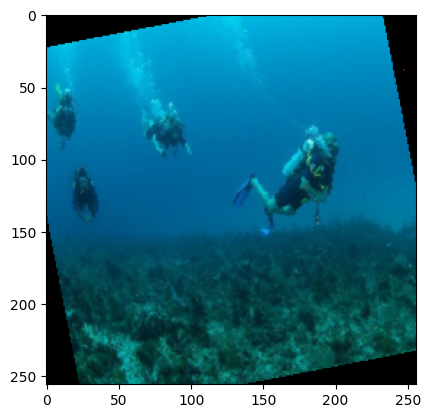

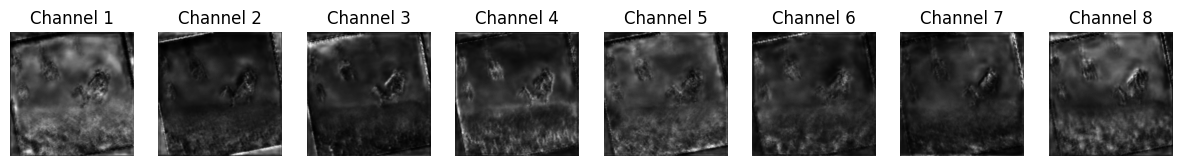

In [ ]:
# Je me suis inspiré du code de Mingrui Ma,Haoyang Li et Mohamed Rachid car j'avais un problème d'éxécution au début
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def concat_skip_path(connection, skip_input, filters, filter_size=3):
    conv_layer = nn.Conv2d(connection.shape[1], filters, kernel_size=filter_size, stride=1, padding='same')
    u = conv_layer(connection)
    u = nn.BatchNorm2d(num_features=filters, momentum=0.8)(u)
    u = torch.cat((u, skip_input), dim=1)
    return u

class CustomEncoder(nn.Module):
    def __init__(self):
        super(CustomEncoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

    def forward(self, x):
        enc1 = self.layer1(x)
        enc2 = self.layer2(enc1)
        enc3 = self.layer3(enc2)
        enc4 = self.layer4(enc3)
        return enc1, enc2, enc3, enc4

class CustomDecoder(nn.Module):
    def __init__(self, n_classes):
        super(CustomDecoder, self).__init__()
        self.dec1 = nn.Conv2d(696, 192, kernel_size=3, padding=1)
        self.bn_dec1 = nn.BatchNorm2d(192)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec2 = nn.Conv2d(1572, 348, kernel_size=3, padding=1)
        self.bn_dec2 = nn.BatchNorm2d(348)
        self.dec3 = nn.Conv2d(512, 786, kernel_size=3, padding=1)
        self.bn_dec3 = nn.BatchNorm2d(786)
        self.output = nn.Conv2d(384, n_classes, kernel_size=3, padding=1)

    def forward(self, enc_1, enc_2, enc_3, enc_4):
        x = enc_4

        x = self.bn_dec3(F.relu(self.dec3(self.upsample(x))))

        x = concat_skip_path(enc_3, x, 786)

        x = self.bn_dec2(F.relu(self.dec2(self.upsample(x))))

        x = concat_skip_path(enc_2, x, 348)

        x = self.bn_dec1(F.relu(self.dec1(self.upsample(x))))

        x = concat_skip_path(enc_1, x, 192)

        x = self.upsample(x)

        out = self.output(x)
        out = F.softmax(out, dim=1)
        return out

class CustomNet(nn.Module):
    def __init__(self, im_res=(256, 256, 3), n_classes=8):
        super(CustomNet, self).__init__()
        self.inp_shape = (im_res[1], im_res[0])
        self.img_shape = (im_res[1], im_res[0], 3)
        self.model = self.create_model(n_classes)

    def create_model(self, n_classes):
        self.encoder = CustomEncoder()
        self.decoder = CustomDecoder(n_classes)
        return self.decoder

    def forward(self, x):
        enc_1, enc_2, enc_3, enc_4 = self.encoder(x)
        out = self.decoder(enc_1, enc_2, enc_3, enc_4)
        return out

model = CustomNet(im_res=(256, 256, 3))
for data, mask in train_loader:
  data1 = data[0]
  plt.imshow(data1)
  break
data = data.permute(0, 3, 1, 2)
output = model(data.float())
tensor = output.permute(0, 3, 2, 1)

tensor_numpy = tensor.squeeze().permute(2, 1, 0).detach().numpy()

fig, axes = plt.subplots(1, 8, figsize=(15, 3))
for i in range(8):
    axes[i].imshow(tensor_numpy[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Channel {i+1}')

plt.show()

Ce code met en œuvre un réseau de segmentation d'images utilisant une architecture encodeur-décodeur VGG.

* Encodeur :  L'encodeur est défini par la classe CustomEncoder, qui consiste en quatre couches convolutionnelles successives, suivies de couches de normalisation et de fonctions d'activation ReLU. Chaque couche diminue la résolution spatiale de l'image et augmente le nombre de canaux.
 Chaque couche du modèle de l'encodeur retourne une représentation de l'image à différentes échelles qui seront utilisées dans le décodeur.
    

* Décodeur : Le décodeur, défini par la classe CustomDecoder, reconstruit une carte de segmentation à partir des représentations obtenues à partir de l'encodeur.
     Les caractéristiques encodées à différentes échelles sont fusionnées avec des chemins de saut (skip connections) pour reconstruire les détails de l'image.
     Le décodeur termine par une couche de convolution pour prédire la carte de segmentation avec le nombre de classes spécifié.
        

  * Réseau complet : La classe CustomNet crée le modèle complet en reliant l'encodeur et le décodeur.
      La méthode forward passe les données d'entrée à travers l'encodeur puis le décodeur pour obtenir la sortie finale, qui est la carte de segmentation.
        

   * Visualisation de la sortie :
        Après avoir passé une image d'entrée par le modèle, la sortie est visualisée en utilisant matplotlib.
        Chaque canal de la sortie représente une classe différente. La visualisation affiche les huit canaux de sortie avec leur index de classe correspondant.

La sortie produite par ce code est une visualisation de la carte de segmentation pour chaque classe dans l'image d'entrée. Chaque canal de sortie représente une classe spécifique, et la visualisation montre la contribution de chaque classe à l'image d'entrée.

***Entraînement:***

Après ça, on s'intéresse à l'entraînement du modèle VGG utilisant PyTorch qui est plus performant que le RSB, comme montré sur le code ci-dessous:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Définir votre modèle, le jeu de données, le DataLoader, etc.

# Définir le modèle
class VGG(nn.Module):
    # Définir l'initialisation du modèle
    def __init__(self, num_classes=1000):
        super(VGG, self).__init__()
        # Définir les couches convolutionnelles pour le modèle VGG
        self.features = nn.Sequential(
            # Ajouter les couches convolutionnelles
        )
        # Définir les couches fully connected pour la classification
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            # Ajouter les couches fully connected
        )

    # Définir la propagation avant du modèle
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Définir votre modèle, votre optimiseur, votre fonction de perte, etc.

# Instancier le modèle
model = VGG()

# Définir l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Définir la fonction de perte
criterion = nn.CrossEntropyLoss()

# Définir le DataLoader pour charger les données
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Entraîner le modèle
num_epochs = 10
for epoch in range(num_epochs):
    # Mettre le modèle en mode entraînement
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for inputs, labels in train_loader:
        # Mettre les données sur le GPU si disponible
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Remettre les gradients à zéro
        optimizer.zero_grad()

        # Faire passer les données dans le modèle
        outputs = model(inputs)

        # Calculer la perte
        loss = criterion(outputs, labels)

        # Rétropropagation et optimisation
        loss.backward()
        optimizer.step()

        # Calculer les statistiques d'entraînement
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculer la perte moyenne et l'exactitude de l'époque
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions

    # Afficher les statistiques d'entraînement de l'époque
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print('Training Finished')


ValueError: optimizer got an empty parameter list

***Conclusion:***

Malgré les difficultés rencontrées et les problèmes d'entraînement auxquels nous avons été confrontés et que nous n'avons pas réussi à résoudre, ce projet nous a permis de comprendre en profondeur différents aspects du Deep Learning, notamment la découverte de nouvelles architectures telles que SUIM-Net en utilisant Keras (en nous appuyant sur un code GitHub comme référence) et le modèle VGG de PyTorch. En adaptant un code existant basé sur Keras et en développant nos propres réseaux de modèles avec PyTorch, nous avons acquis une expérience précieuse. De plus, nous avons étudié le modèle VGG qui s'est avéré plus performant que le modèle RSB en termes de généralisation. Nous avons rencontré des erreurs comme illustré dans le code lors de la phase d'entraînement pour les tester sur les modèles RSB et VGG. Ce type d'algorithme est crucial pour la technologie de vision par ordinateur appliquée à la détection sous-marine, offrant un soutien technique essentiel au développement des technologies sous-marines.

***Références:***

1- https://github.com/xahidbuffon/SUIM/tree/master/models \
